In [1]:
from pathlib import Path
import yaml
from ultralytics.models import YOLO
import torch
from IPython.display import Image as IPImage, display

In [2]:
TRASHCAN_DATASET = Path("trashcan_dataset")
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

print(f"Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA: {torch.version.cuda}")

Device: cuda:0
GPU: NVIDIA GeForce RTX 3080 Laptop GPU
CUDA: 12.8


## Verify Dataset Structure

In [3]:
# Check dataset structure
train_images = list((TRASHCAN_DATASET / "train" / "images").glob("*"))
train_labels = list((TRASHCAN_DATASET / "train" / "labels").glob("*.txt"))
valid_images = list((TRASHCAN_DATASET / "valid" / "images").glob("*"))
valid_labels = list((TRASHCAN_DATASET / "valid" / "labels").glob("*.txt"))

print(f"Train: {len(train_images)} images, {len(train_labels)} labels")
print(f"Valid: {len(valid_images)} images, {len(valid_labels)} labels")

Train: 3778 images, 1889 labels
Valid: 142 images, 71 labels


In [4]:
# Check number of classes in dataset
import numpy as np

all_classes = set()
for label_file in (TRASHCAN_DATASET / "train" / "labels").glob("*.txt"):
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if parts:
                all_classes.add(int(parts[0]))

print(f"Number of classes found: {len(all_classes)}")
print(f"Class IDs: {sorted(all_classes)}")

Number of classes found: 67
Class IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]


## Create data.yaml

In [5]:
# Generate class names dynamically
num_classes = 67  # Based on dataset inspection (classes 0-66)
class_names = {i: f'trashcan_type_{i}' for i in range(num_classes)}

yaml_data = {
    'path': str(TRASHCAN_DATASET.absolute()),
    'train': 'train/images',
    'val': 'valid/images',
    'nc': num_classes,
    'names': class_names
}

yaml_path = TRASHCAN_DATASET / 'data.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_data, f, default_flow_style=False)

print(f"Created: {yaml_path}")
print(f"Number of classes: {num_classes}")

Created: trashcan_dataset/data.yaml
Number of classes: 67


## Train Model

In [6]:
model = YOLO('yolo11n-seg.pt')
head_idx = next((i for i, m in enumerate(model.model.model) if 'Detect' in m.__class__.__name__ or 'Segment' in m.__class__.__name__), len(model.model.model) - 1)
print(f"Head starts at layer: {head_idx}")
print(f"Freezing layers: 0-{head_idx-1}")

Head starts at layer: 23
Freezing layers: 0-22


In [7]:
results = model.train(
    data=str(yaml_path),
    freeze=list(range(head_idx)),
    epochs=5,
    imgsz=640,
    batch=16,
    device=DEVICE,
    project='runs/segment',
    name='trashcan_model',
    exist_ok=True,
    pretrained=True,
    optimizer='Adam',
    lr0=0.001,
    patience=10,
    save=True,
    plots=True,
    workers=0,
    val=True,
    hsv_h=0.01,
    hsv_s=0.5,
    hsv_v=0.3,
    degrees=5.0,
    translate=0.1,
    scale=0.3,
    flipud=0.0,
    fliplr=0.5,
    mosaic=0.5
)

print(f"Model saved: runs/segment/trashcan_model/weights/best.pt")

Ultralytics 8.3.235 🚀 Python-3.12.10 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 3080 Laptop GPU, 8192MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=trashcan_dataset/data.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22], half=False, hsv_h=0.01, hsv_s=0.5, hsv_v=0.3, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.pt, momentum=0.937, mosaic=0.5, multi_scale=False, name=trashcan_model, nbs=64, nms=False, ops

## Load Trained Model

In [8]:
model = YOLO('runs/segment/trashcan_model/weights/best.pt')

## Validation

In [9]:
metrics = model.val(
    data=str(yaml_path),
    batch=8,
    workers=0,
    device=DEVICE
)

print(f"Box - mAP50: {metrics.box.map50:.4f}, mAP50-95: {metrics.box.map:.4f}")
print(f"Mask - mAP50: {metrics.seg.map50:.4f}, mAP50-95: {metrics.seg.map:.4f}")

Ultralytics 8.3.235 🚀 Python-3.12.10 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 3080 Laptop GPU, 8192MiB)
YOLO11n-seg summary (fused): 113 layers, 2,850,867 parameters, 0 gradients, 9.7 GFLOPs
YOLO11n-seg summary (fused): 113 layers, 2,850,867 parameters, 0 gradients, 9.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3608.8±2023.6 MB/s, size: 364.9 KB)
val: Scanning /home/tonino/projects/ball segmentation/trashcan_dataset/valid/labels.cache... 71 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 71/71 62.9Kit/s 0.0s
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3608.8±2023.6 MB/s, size: 364.9 KB)
val: Scanning /home/tonino/projects/ball segmentation/trashcan_dataset/valid/labels.cache... 71 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 71/71 62.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 1.7it/s 5.4s0.5ss
                 Class     Images 

## View Training Results

results.png:


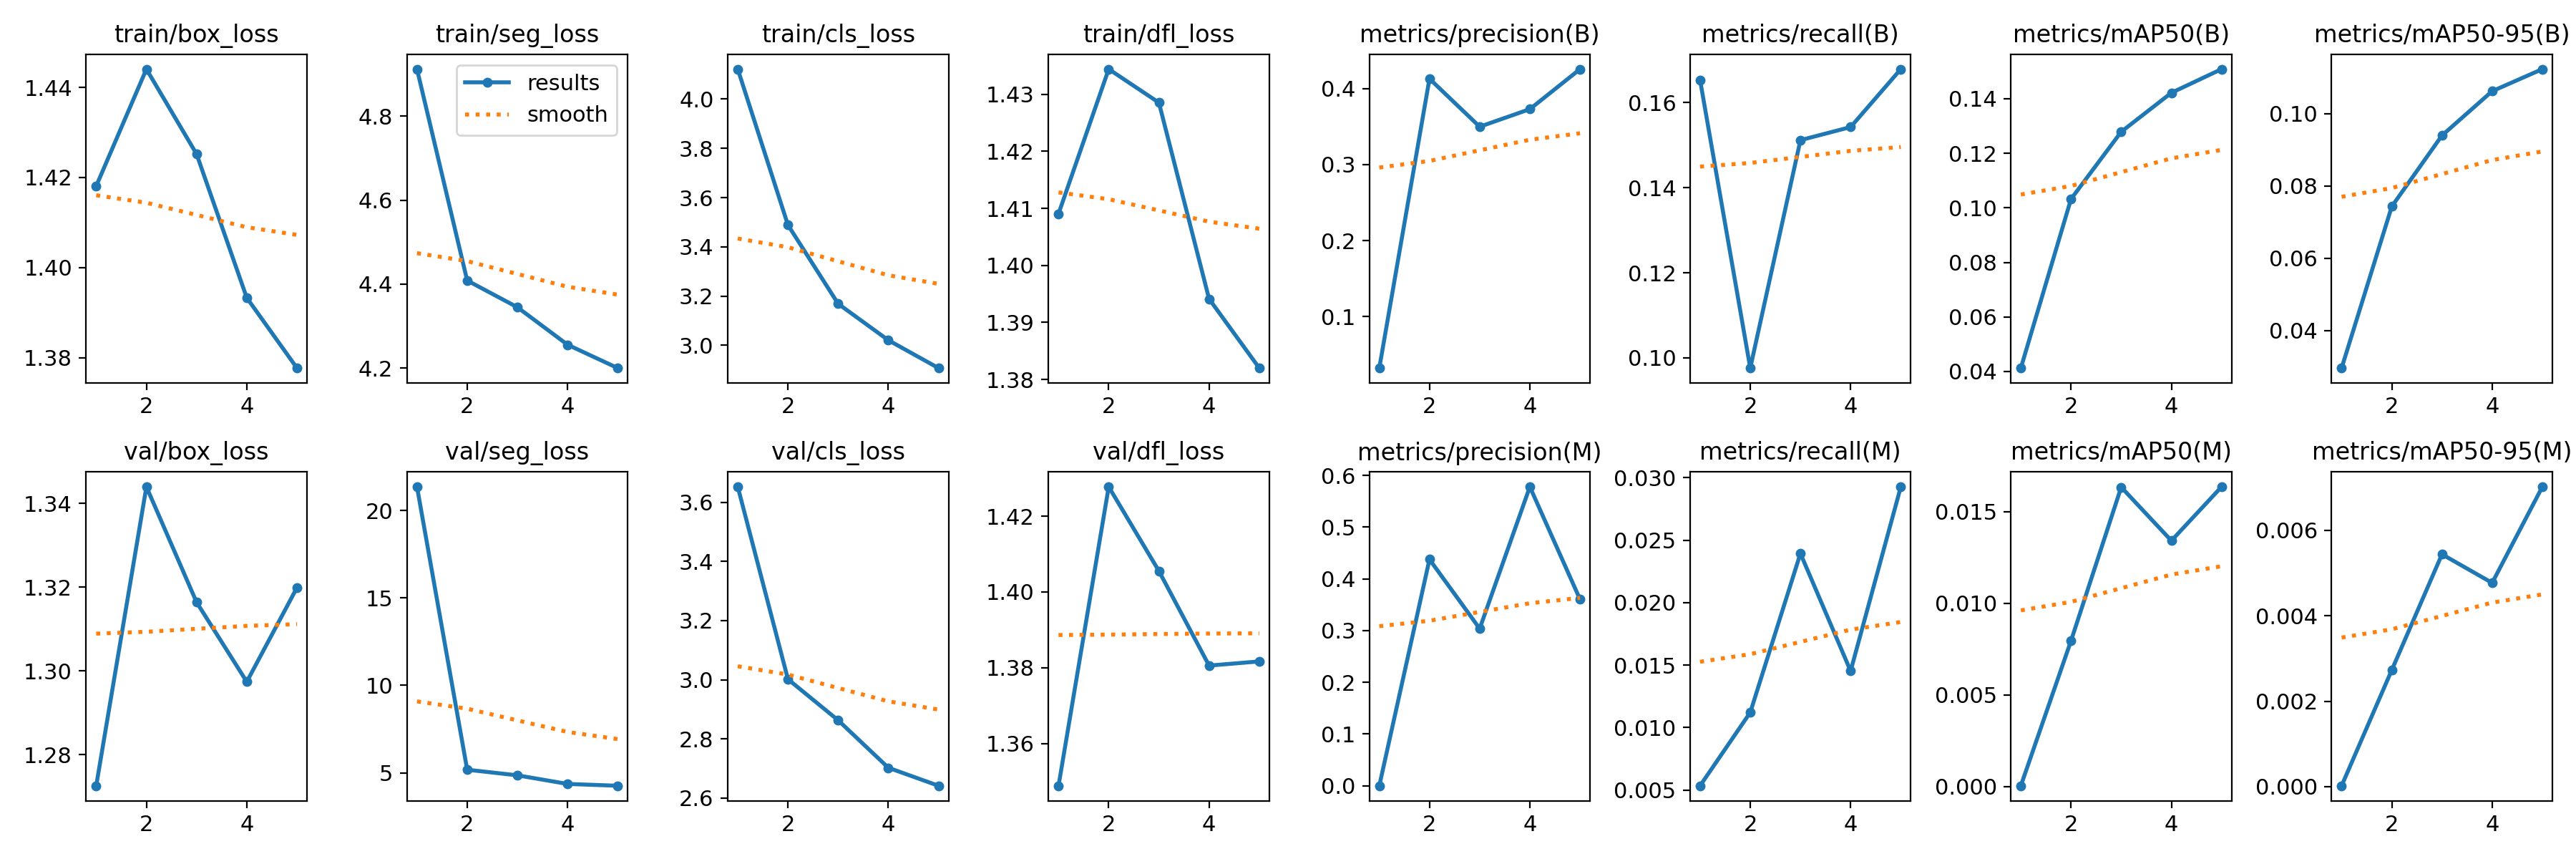

confusion_matrix.png:


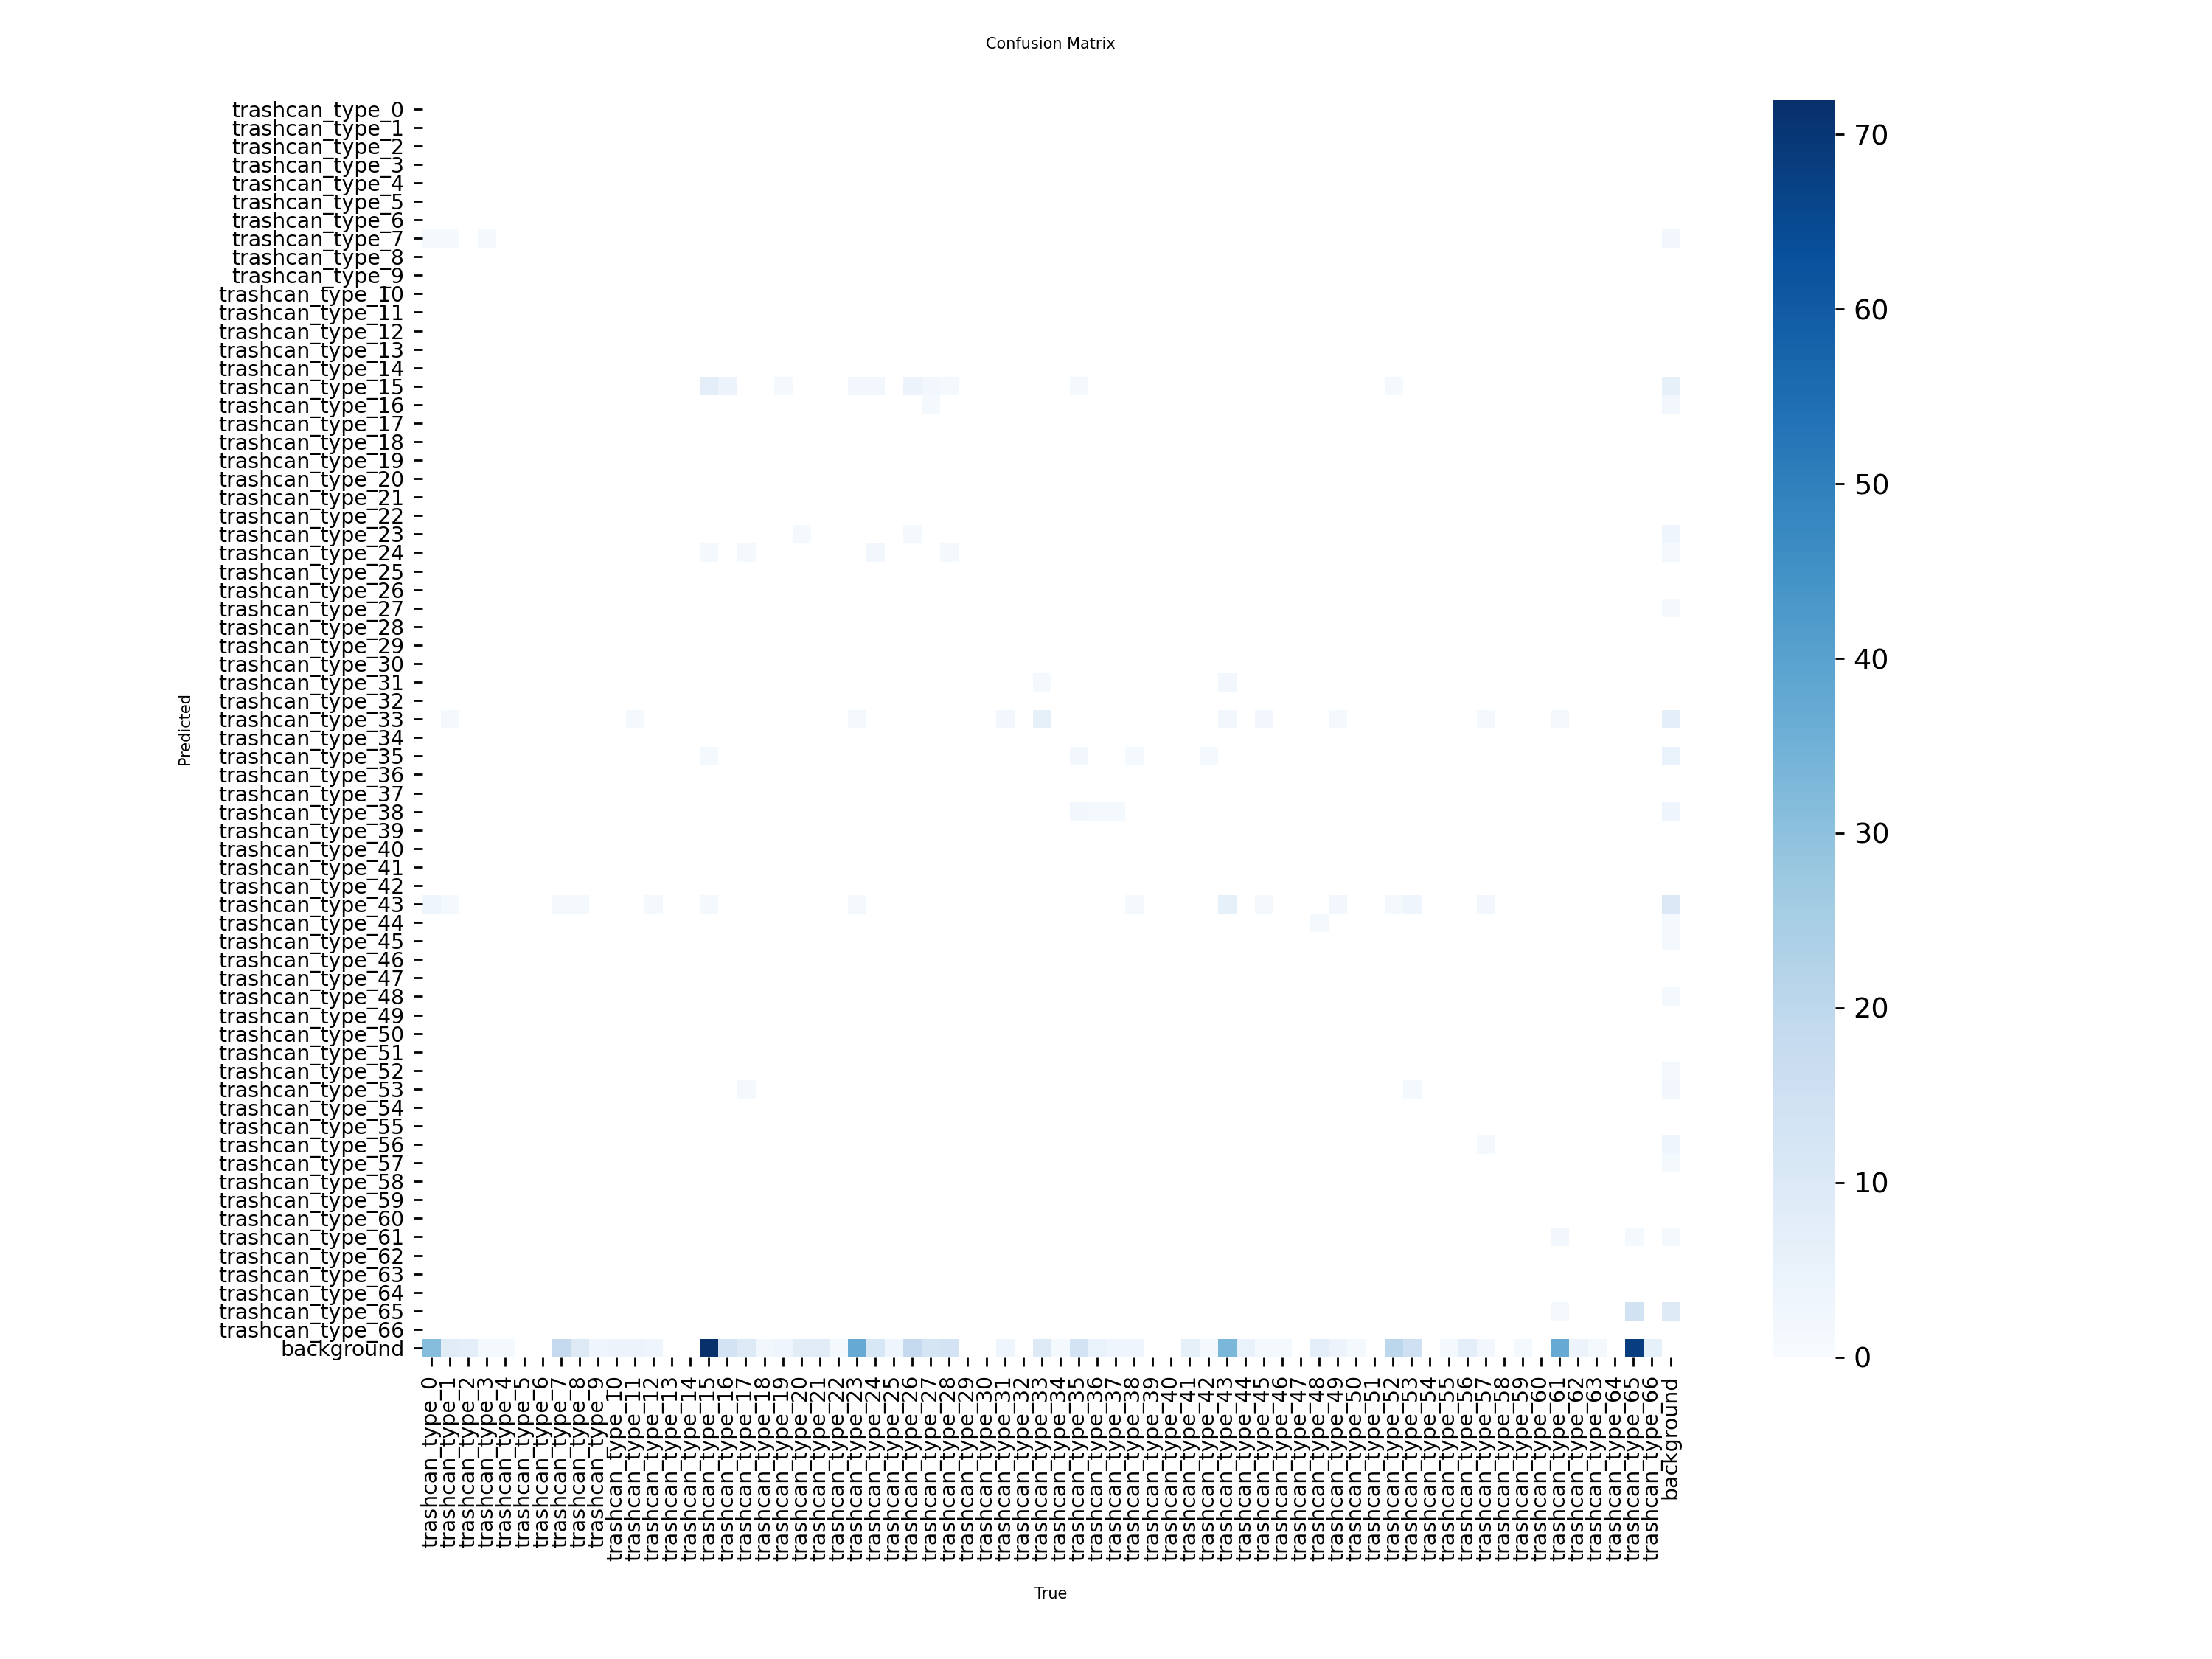

val_batch0_labels.jpg:


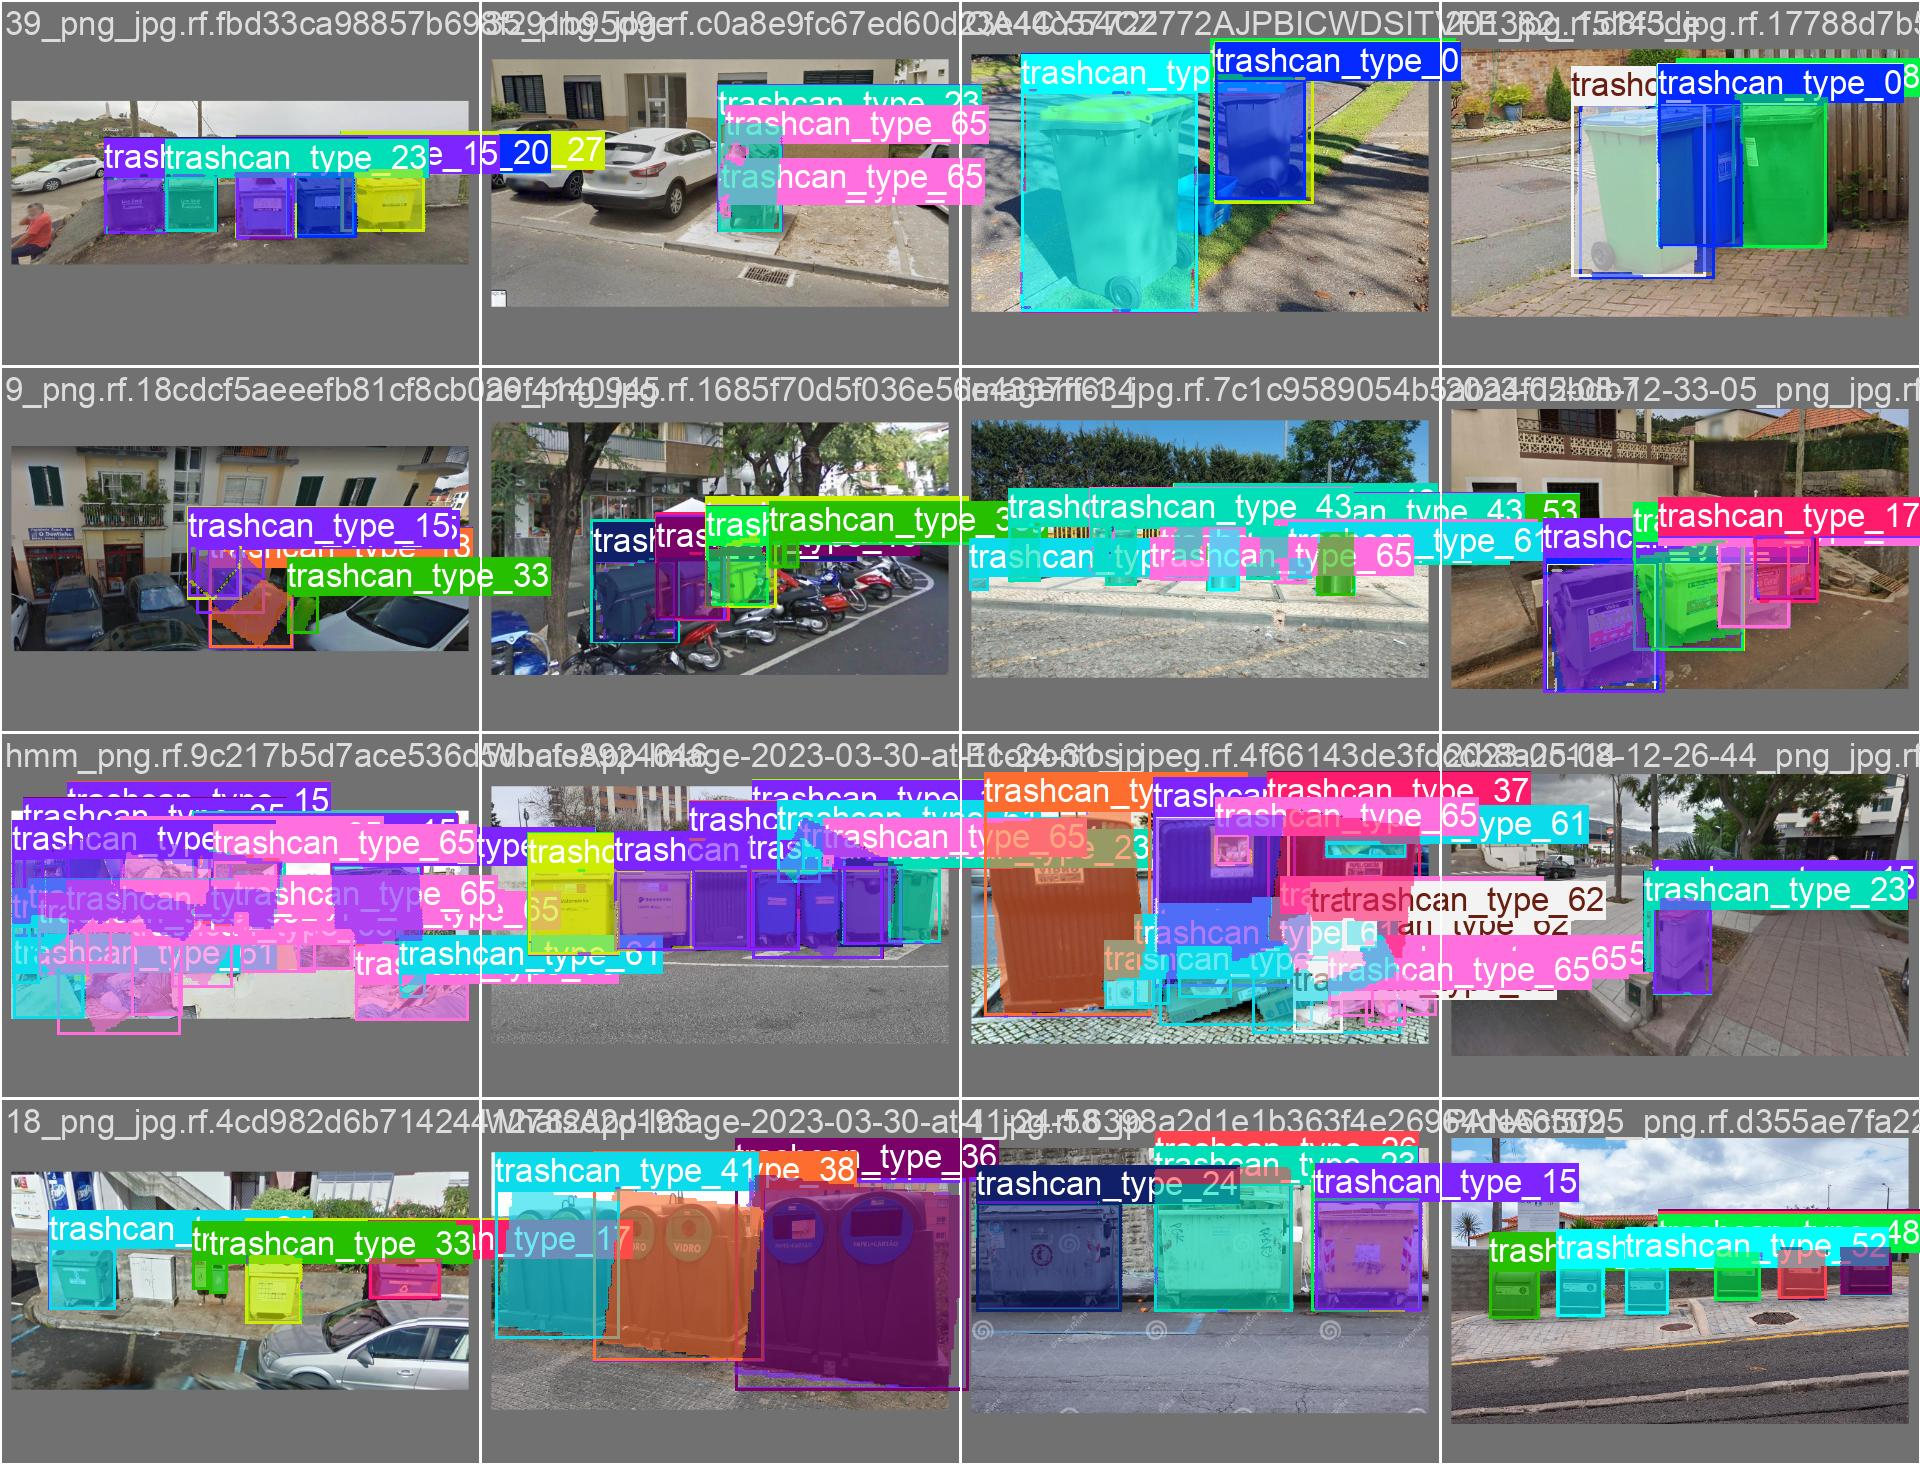

val_batch0_pred.jpg:


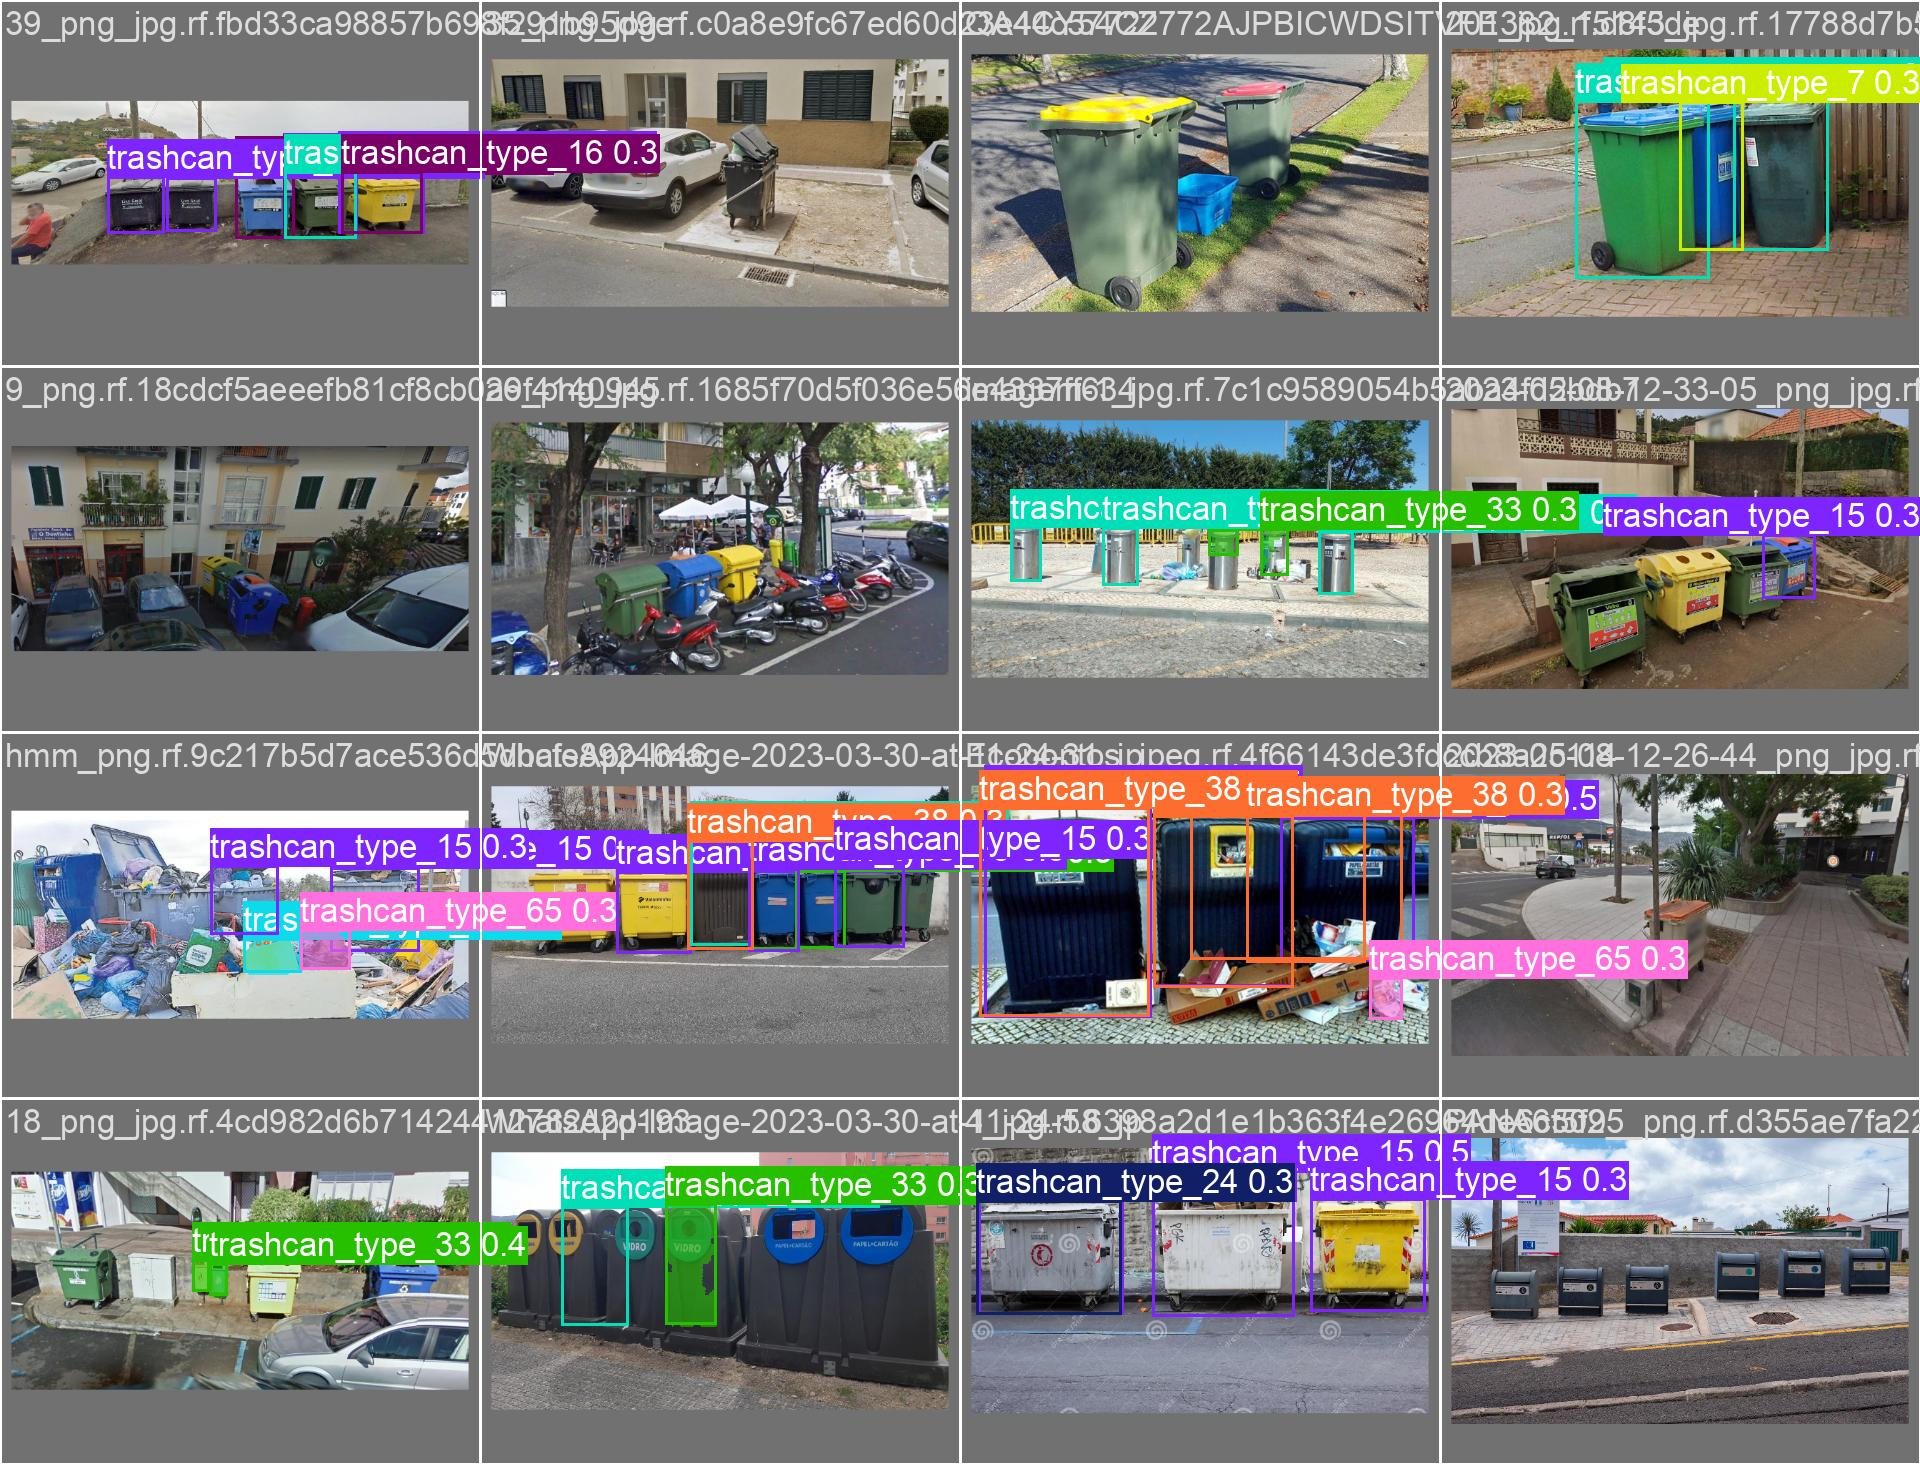

In [10]:
results_dir = Path('runs/segment/trashcan_model')

if results_dir.exists():
    plots = ['results.png', 'confusion_matrix.png', 'val_batch0_labels.jpg', 'val_batch0_pred.jpg']
    
    for plot in plots:
        plot_path = results_dir / plot
        if plot_path.exists():
            print(f"{plot}:")
            display(IPImage(filename=str(plot_path), width=800))

## Test on Image


image 1/1 /home/tonino/projects/ball segmentation/df/validbin.jpg: 640x480 1 trashcan_type_65, 227.5ms
Speed: 5.4ms preprocess, 227.5ms inference, 7.8ms postprocess per image at shape (1, 3, 640, 480)
Results saved to /home/tonino/projects/ball segmentation/runs/segment/trashcan_pred
image 1/1 /home/tonino/projects/ball segmentation/df/validbin.jpg: 640x480 1 trashcan_type_65, 227.5ms
Speed: 5.4ms preprocess, 227.5ms inference, 7.8ms postprocess per image at shape (1, 3, 640, 480)
Results saved to /home/tonino/projects/ball segmentation/runs/segment/trashcan_pred
Detected 1 trashcan(s)
  Trashcan 1: 0.279
Detected 1 trashcan(s)
  Trashcan 1: 0.279


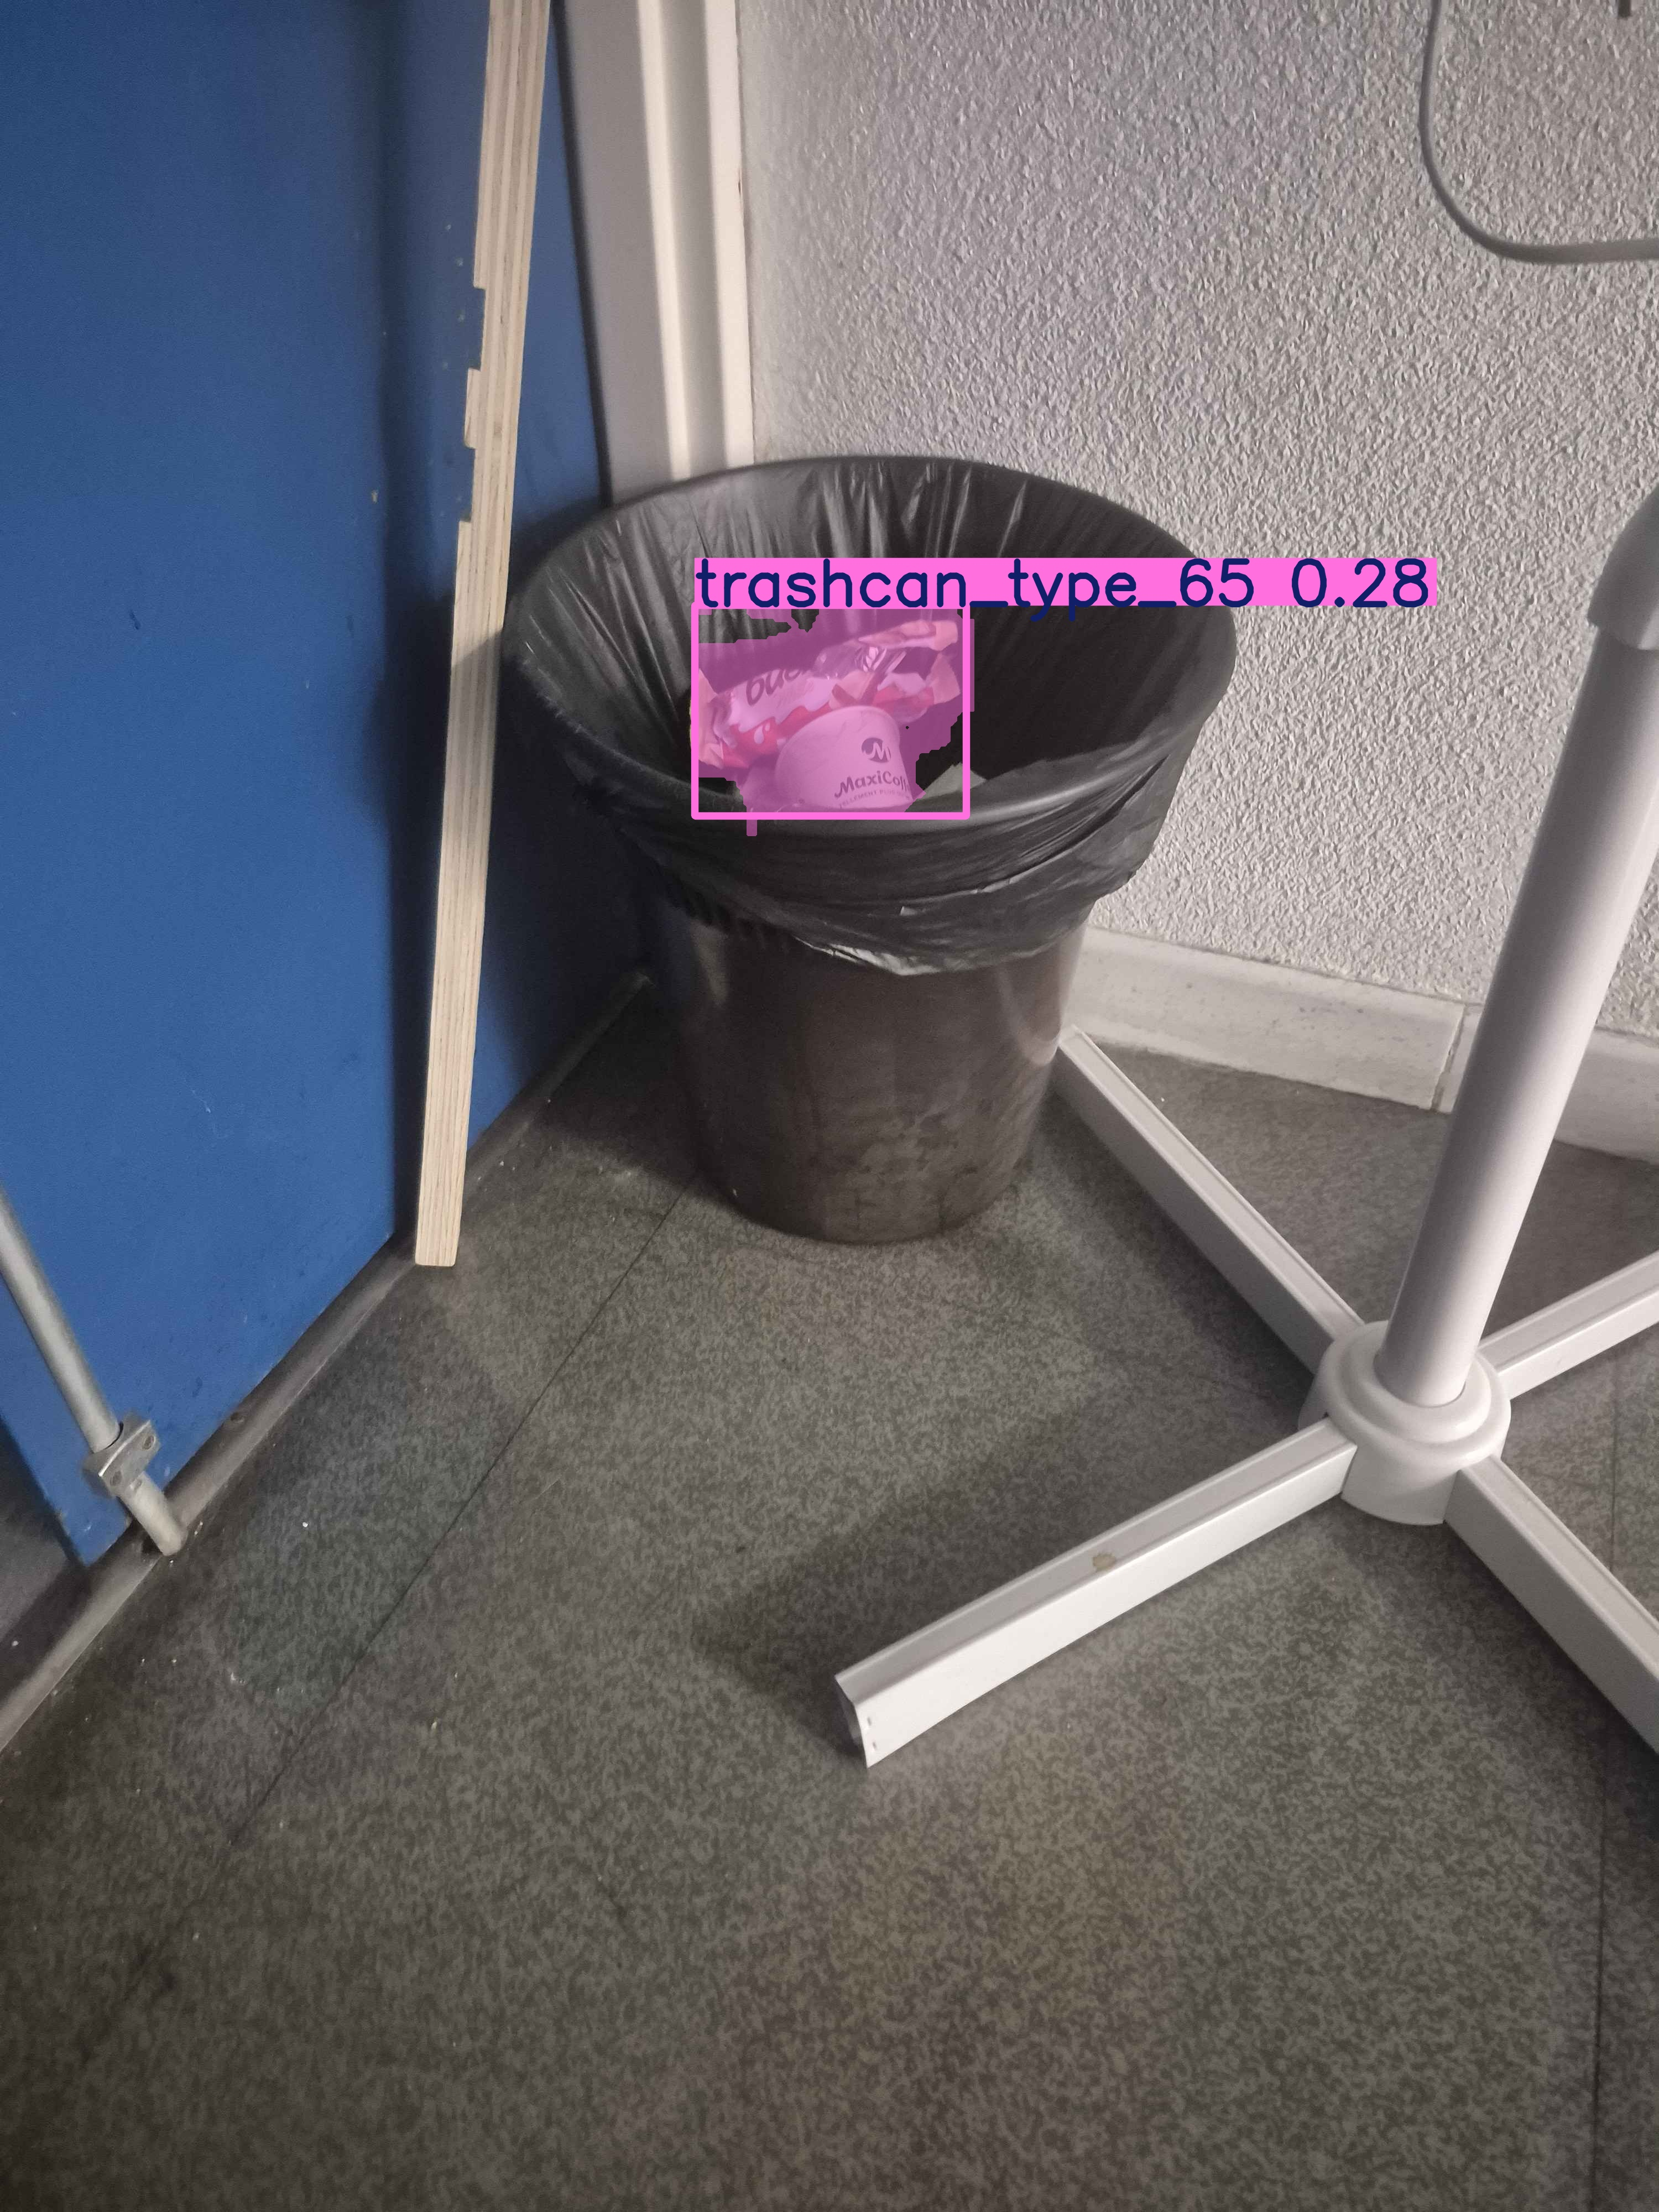

In [11]:
test_img = Path("df") / "validbin.jpg"

results = model.predict(
    source=str(test_img),
    save=True,
    conf=0.25,
    device=DEVICE,
    project='runs/segment',
    name='trashcan_pred',
    exist_ok=True
)

for r in results:
    if r.boxes is not None and len(r.boxes) > 0:
        print(f"Detected {len(r.boxes)} trashcan(s)")
        for i, conf in enumerate(r.boxes.conf):
            print(f"  Trashcan {i+1}: {conf:.3f}")
    else:
        print("No detections")

pred_path = Path('runs/segment/trashcan_pred') / test_img.name
if pred_path.exists():
    display(IPImage(filename=str(pred_path), width=640))